<a href="https://colab.research.google.com/github/aparnay2002/AI---HW-Tools-Projects/blob/main/Apache%20Spark/apache_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark
!pip install findspark
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder.appName("Covid Data Mining").config('spark.sql.debug.maxToStringFields', 2000).getOrCreate()


In [ ]:
file = 'owid-covid-data.csv'
full_df = spark.read.csv(file, header=True, inferSchema=True)

In [ ]:
print(f"The total number of samples is {full_df.count()}, with each sample corresponding to {len(full_df.columns)} features.")
full_df.printSchema()

The total number of samples is 176224, with each sample corresponding to 67 features.
root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: string (nullable = true)
 |-- total_cases: double (nullable = true)
 |-- new_cases: double (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_deaths: double (nullable = true)
 |-- new_deaths: double (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- reproduction_rate: double (nullable = true)
 |-- icu_patients: double (nullable = true)
 |-- icu_patients_per_million: double (nullab

In [ ]:
full_df.select("iso_code","location","continent","date","tests_units").show(5)

+--------+-----------+---------+----------+-----------+
|iso_code|   location|continent|      date|tests_units|
+--------+-----------+---------+----------+-----------+
|     AFG|Afghanistan|     Asia|2020-02-24|       null|
|     AFG|Afghanistan|     Asia|2020-02-25|       null|
|     AFG|Afghanistan|     Asia|2020-02-26|       null|
|     AFG|Afghanistan|     Asia|2020-02-27|       null|
|     AFG|Afghanistan|     Asia|2020-02-28|       null|
+--------+-----------+---------+----------+-----------+
only showing top 5 rows



In [ ]:
from pyspark.sql import functions as F

miss_vals = full_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in full_df.columns]).collect()[0].asDict()
miss_vals = dict(sorted(miss_vals.items(), reverse=True, key=lambda item: item[1]))

import pandas as pd

pd.DataFrame.from_records([miss_vals])

,weekly_icu_admissions,weekly_icu_admissions_per_million,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_boosters,total_boosters_per_hundred,...,new_cases_smoothed_per_million,new_cases_smoothed,new_cases_per_million,total_cases_per_million,new_cases,total_cases,population,iso_code,location,date
0,170498,170498,170201,170201,170201,170201,164813,164813,155973,155973,...,9320,8539,7331,7106,6544,6319,1104,0,0,0


In [ ]:
full_df = full_df.withColumn('date',F.to_date(F.unix_timestamp(F.col('date'), 'yyyy-MM-dd').cast("timestamp")))

In [ ]:
dates = ("2021-01-01", "2021-02-28")
df = full_df.where(F.col('date').between(*dates))

In [ ]:
print(f"The total number of samples is {df.count()}, with each sample corresponding to {len(df.columns)} features.")

miss_vals = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).collect()[0].asDict()
miss_vals = dict(sorted(miss_vals.items(), reverse=True, key=lambda item: item[1]))

pd.DataFrame.from_records([miss_vals])

The total number of samples is 13515, with each sample corresponding to 67 features.


,weekly_icu_admissions,weekly_icu_admissions_per_million,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,total_boosters,total_boosters_per_hundred,weekly_hosp_admissions,weekly_hosp_admissions_per_million,...,new_cases_smoothed_per_million,new_cases_per_million,total_cases_per_million,new_cases_smoothed,new_cases,total_cases,population,iso_code,location,date
0,13029,13029,13010,13010,13010,13010,12765,12765,12581,12581,...,412,382,378,353,323,319,105,0,0,0


In [ ]:
df.sort("continent").select("iso_code","continent","location").show(5)
df = df.fillna({'continent':'OWID'})
df.select("tests_units").distinct().show()
df = df.fillna({'tests_units':'no info'})
df = df.fillna(0)
miss_vals = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).collect()[0].asDict()
if any(list(miss_vals.values())) != 0:
    print("There are still missing values in the DataFrame.")
else:
    print("All missing values have been taken care of.")

+--------+---------+-------------+
|iso_code|continent|     location|
+--------+---------+-------------+
|OWID_NAM|     null|North America|
|OWID_NAM|     null|North America|
|OWID_NAM|     null|North America|
|OWID_NAM|     null|North America|
|OWID_NAM|     null|North America|
+--------+---------+-------------+
only showing top 5 rows

+---------------+
|    tests_units|
+---------------+
|           null|
|  people tested|
| samples tested|
|tests performed|
|  units unclear|
+---------------+

All missing values have been taken care of.


In [ ]:
miss_vals = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).collect()[0].asDict()
if any(list(miss_vals.values())) != 0:
    print("There are still missing values in the DataFrame.")
else:
    print("All missing values have been taken care of.")

All missing values have been taken care of.


In [ ]:
def OutlierDetector(dataframe, features, alpha=1.5):
    """
    Args:
        dataframe (pyspark.sql.dataframe.DataFrame):
            the DataFrame hosting the data
        features (string or List):
            List of features (columns) for which we wish to identify outliers.
            If set equal to 'all', outliers are identified with respect to all features.
        alpha (double):
            The parameter that defines the decision boundary (see markdown above)
    """
    feat_types = dict(dataframe.dtypes)
    if features == 'all':
        features = dataframe.columns
        
    outliers_cols = []
    
    for feat in features:
        # We only care for quantitative features
        if feat_types[feat] == 'double':
            Q1, Q3 = dataframe.approxQuantile(feat, [0.25, 0.75], 0)
            R = Q3 - Q1
            lower_bound = Q1 - (R * alpha)
            upper_bound = Q3 + (R * alpha)
            
            # In this way we construct a query, which can be matched to a DataFrame column, thus returning a new
            # column where every point that corresponds to an Outlier has a boolean value set to True
            outliers_cols.append(F.when(~F.col(feat).between(lower_bound, upper_bound), True).alias(feat + '_outlier'))
    
    # Sample points that do not correspond to outliers correspond to a False value for the new column
    outlier_df = dataframe.select(*outliers_cols)
    outlier_df = outlier_df.fillna(False)
    return outlier_df

In [ ]:
out_df = OutlierDetector(dataframe=df, features=['new_cases'], alpha=1.5)
out_df.show(5)

+-----------------+
|new_cases_outlier|
+-----------------+
|            false|
|            false|
|            false|
|            false|
|            false|
+-----------------+
only showing top 5 rows



In [ ]:
if df.count() != df.select(['location','date']).distinct().count():
    print("There are duplicate entries present in the DataFrame.")
else:
    print("Either there are no duplicate entries present in the DataFrame, or all of them have already been removed).")

Either there are no duplicate entries present in the DataFrame, or all of them have already been removed).


In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap, LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

def CustomCmap(from_rgb,to_rgb):

    # from color r,g,b
    r1,g1,b1 = from_rgb

    # to color r,g,b
    r2,g2,b2 = to_rgb

    cdict = {'red': ((0, r1, r1),
                   (1, r2, r2)),
           'green': ((0, g1, g1),
                    (1, g2, g2)),
           'blue': ((0, b1, b1),
                   (1, b2, b2))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

mycmap = CustomCmap([1.0, 1.0, 1.0], [72/255, 99/255, 147/255])
mycmap_r = CustomCmap([72/255, 99/255, 147/255], [1.0, 1.0, 1.0])

mycol = (72/255, 99/255, 147/255)
mycomplcol = (129/255, 143/255, 163/255)
othercol1 = (135/255, 121/255, 215/255)
othercol2 = (57/255, 119/255, 171/255)
othercol3 = (68/255, 81/255, 91/255)
othercol4 = (73/255, 149/255, 139/255)

In [ ]:
dates_frame = df.select("date").distinct().orderBy('date').collect()
dates_list = [str(dates_frame[x][0]) for x in range(len(dates_frame))]

In [ ]:
df_for_mort = df.filter(F.col('population') != 0.0).withColumn("mortality", F.col("total_deaths")/F.col("population"))

for i, this_day in enumerate(dates_list):
    this_day_top_10 = df_for_mort.filter(F.col('date') == this_day).orderBy("mortality", ascending=False).select(["location","mortality"]).take(10)
    if i == 0:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("During "+this_day+", the top 10 countries with the highest mortality rate were:")
        for country, instance in ct_list:
            print(f"▶ {country}, with mortality rate {100*instance:.2f}%.")
        new_set = set(ct_list[x][0] for x in range(10))
    elif i == len(dates_list)-1:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("During "+this_day+", the top 10 countries with the highest mortality rate were:")
        for country, instance in ct_list:
            print(f"▶ {country}, with mortality rate {100*instance:.2f}%.")
    else:
        new_set = set(this_day_top_10[x][0] for x in range(10))
        if new_set != old_set:
            left_out = old_set-new_set
            new_additions = new_set-old_set
            print("This was the top ten until "+this_day+", when "+", ".join(str(s) for s in new_additions)+" joined the list, replacing "+", ".join(str(s) for s in left_out)+".")
    new_set, old_set = set(), new_set

During 2021-01-01, the top 10 countries with the highest mortality rate were:
▶ Peru, with mortality rate 0.28%.
▶ San Marino, with mortality rate 0.17%.
▶ Belgium, with mortality rate 0.17%.
▶ Slovenia, with mortality rate 0.13%.
▶ Bosnia and Herzegovina, with mortality rate 0.13%.
▶ Italy, with mortality rate 0.12%.
▶ North Macedonia, with mortality rate 0.12%.
▶ Liechtenstein, with mortality rate 0.12%.
▶ Bulgaria, with mortality rate 0.11%.
▶ Czechia, with mortality rate 0.11%.
This was the top ten until 2021-01-08, when United Kingdom joined the list, replacing Bulgaria.
This was the top ten until 2021-01-18, when Gibraltar joined the list, replacing North Macedonia.
This was the top ten until 2021-02-03, when North Macedonia joined the list, replacing Liechtenstein.
This was the top ten until 2021-02-05, when United States joined the list, replacing North Macedonia.
This was the top ten until 2021-02-08, when North Macedonia joined the list, replacing United States.
This was the 

In [ ]:
for i, this_day in enumerate(dates_list):
    this_day_top_10 = df.filter(F.col('date') == this_day).orderBy("total_cases_per_million", ascending=False).select(["location","total_cases_per_million"]).take(10)
    if i == 0:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("During "+this_day+", the top 10 countries with the highest number of total cases per million were:")
        for country, instance in ct_list:
            print(f"▶ {country}, with {instance} total cases per million.")
        new_set = set(ct_list[x][0] for x in range(10))
    elif i == len(dates_list)-1:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("During "+this_day+", the top 10 countries with the highest number of total cases per million were:")
        for country, instance in ct_list:
            print(f"▶ {country}, with {instance} total cases per million.")
    else:
        new_set = set(this_day_top_10[x][0] for x in range(10))
        if new_set != old_set:
            left_out = old_set-new_set
            new_additions = new_set-old_set
            print("This was the top ten until "+this_day+", when "+", ".join(str(s) for s in new_additions)+" joined the list, replacing "+", ".join(str(s) for s in left_out)+".")
    new_set, old_set = set(), new_set

During 2021-01-01, the top 10 countries with the highest number of total cases per million were:
▶ Andorra, with 104933.164 total cases per million.
▶ Montenegro, with 77364.736 total cases per million.
▶ Luxembourg, with 73115.905 total cases per million.
▶ San Marino, with 70097.03 total cases per million.
▶ Czechia, with 68256.644 total cases per million.
▶ Gibraltar, with 65655.516 total cases per million.
▶ United States, with 61189.671 total cases per million.
▶ French Polynesia, with 59907.834 total cases per million.
▶ Slovenia, with 59627.954 total cases per million.
▶ Liechtenstein, with 58686.673 total cases per million.
This was the top ten until 2021-01-07, when Panama joined the list, replacing French Polynesia.
This was the top ten until 2021-01-13, when Slovakia joined the list, replacing Liechtenstein.
This was the top ten until 2021-02-05, when Portugal joined the list, replacing Panama.
This was the top ten until 2021-02-10, when Israel joined the list, replacing Por

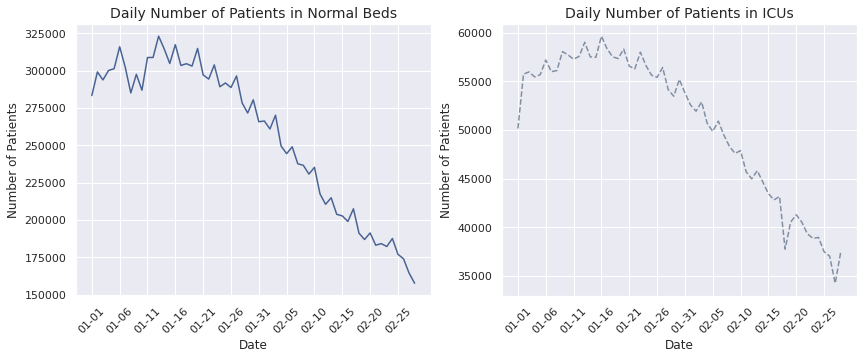

In [ ]:
dt_ord = df.orderBy("date", ascending=True).groupBy("date")

hosps = dt_ord.agg(F.sum("hosp_patients")).collect()
hosps = [hosps[i][1] for i in range(len(hosps))]

icus = dt_ord.agg(F.sum("icu_patients")).collect()
icus = [icus[i][1] for i in range(len(icus))]

sns.set(style = "darkgrid")

alt_dts_list = [dt.replace('2021-', '') for dt in dates_list]
tick_marks = np.arange(len(alt_dts_list))

fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for pat, col, style, ax, where in zip([hosps,icus], [mycol, mycomplcol],
                                      ['solid', 'dashed'], [ax1,ax2], ['Normal Beds','ICUs']): 
    ax.plot(alt_dts_list, pat, linestyle=style, color=col)
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Patients")
    ax.set_title(f"Daily Number of Patients in {where}", fontsize=14)
    ax.set_xticks(tick_marks[::5])
    ax.set_xticklabels(alt_dts_list[::5], rotation=45)
    
plt.show()

matplotlib.rc_file_defaults()

In [ ]:
import requests, zipfile
from io import BytesIO

zip_file_url = "https://srigas.me/kaggle/owid-nb-data.zip"

request = requests.get(zip_file_url)
zipDocument = zipfile.ZipFile(BytesIO(request.content))

zipDocument.extractall()

In [ ]:
!pip install geopandas
import geopandas as gpd

shapefile = 'countries.shp'
geo_df = gpd.read_file(shapefile)[['ADMIN','ADM0_A3','geometry']]
geo_df.columns = ['location', 'iso_code', 'geometry']
geo_df = geo_df.drop(geo_df.loc[geo_df['location'] == 'Antarctica'].index) # exclude Antarctica

     |████████████████████████████████| 1.0 MB 7.7 MB/s 
     |████████████████████████████████| 16.7 MB 276 kB/s 
     |████████████████████████████████| 6.3 MB 40.0 MB/s 


In [ ]:
print('Initializing the construction of heatmaps for every day.')

ct = 0
for this_day in dates_list:
    # The conversion of the required columns into a Pandas df is necessary to perform the mapping
    day_df = df.filter(F.col('date') == this_day).select(["iso_code","total_cases"]).toPandas()

    merged_df = pd.merge(left=geo_df, right=day_df, how='left', left_on='iso_code', right_on='iso_code')

    title = f'Total COVID-19 Cases as of {this_day}'
    col = 'total_cases'
    vmin, vmax = merged_df[col].min(), merged_df[col].max()
    cmap = mycmap
    divnorm = TwoSlopeNorm(vcenter=0.08*20365726)

    # Create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(20, 8))

    # Remove the axis
    ax.axis('off')
    merged_df.plot(column=col, ax=ax, edgecolor='1.0', linewidth=1, norm=divnorm, cmap=cmap)

    # Add a title
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

    # Empty array for the data range
    sm._A = []

    # Add the colorbar to the figure
    cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
    cbar = fig.colorbar(sm, cax=cbaxes)
    plt.savefig(f'world_map_{this_day}.png', bbox_inches='tight')
    plt.close(fig)
    ct += 1

print(f'Process complete. {ct} heatmap(s) were extracted, ready to be converted into a .gif file.')

Initializing the construction of heatmaps for every day.
Process complete. 59 heatmap(s) were extracted, ready to be converted into a .gif file.


In [ ]:
exc_dates_list = df.filter(F.col('excess_mortality') != 0.0).select(['date']).distinct().orderBy('date').collect()
exc_dates_list = [str(exc_dates_list[i][0]) for i in range(len(exc_dates_list))]

In [ ]:
print('Initializing the construction of heatmaps for every day.')

ct = 0
for this_day in exc_dates_list:
    europe_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Europe').filter(F.col('excess_mortality') != 0.0).select(["iso_code","excess_mortality"])
    
    geo_eu = pd.merge(left=geo_df, right=europe_df.toPandas(), how='inner', on='iso_code')

    fig, ax = plt.subplots(1,1)

    col = 'excess_mortality'
    cmap = mycmap

    vmin, vmax = geo_eu[col].min(), geo_eu[col].max()
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

    ax.axis('off')
    ax.axis([-13, 44, 33, 72])
    geo_eu.plot(column=col, ax=ax, edgecolor='1.0', linewidth=1, norm=None, cmap=cmap)
    ax.set_title(f'Excess Mortality in Europe as of {this_day}', fontdict={'fontsize': '14', 'fontweight': '3'})
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=.2)
    fig.add_axes(cax)
    fig.colorbar(sm, cax=cax)
    plt.savefig(f'europe_{this_day}.png', bbox_inches='tight')
    plt.close(fig)
    ct += 1
    
print(f'Process complete. {ct} heatmap(s) were extracted, ready to be converted into a .gif file.')

Initializing the construction of heatmaps for every day.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

Process complete. 9 heatmap(s) were extracted, ready to be converted into a .gif file.


In [ ]:
european_df = df.filter(F.col('continent') == 'Europe').filter(F.col('excess_mortality') != 0.0)
european_cts = european_df.select(['location']).distinct().collect()
european_cts = [european_cts[i][0] for i in range(len(european_cts)) if european_df.filter(F.col('location') == european_cts[i][0]).count() == len(exc_dates_list)]
print(f'{len(european_cts)} European countries are chosen for this analysis.')

31 European countries are chosen for this analysis.


In [ ]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

eu_cts_df = european_df.filter(F.col('location') == european_cts[0]).select(['excess_mortality']).withColumnRenamed("excess_mortality", european_cts[0])
# required for the proper join of the following DataFrames
eu_cts_df = eu_cts_df.withColumn('row_index', row_number().over(Window.partitionBy(F.lit(0)).orderBy(monotonically_increasing_id())))

for country in european_cts[1:]:
    new_ct_df = european_df.filter(F.col('location') == country).select(['excess_mortality']).withColumnRenamed("excess_mortality", country)
    new_ct_df = new_ct_df.withColumn('row_index', row_number().over(Window.partitionBy(F.lit(0)).orderBy(monotonically_increasing_id())))
    
    eu_cts_df = eu_cts_df.join(new_ct_df, on=["row_index"])
    
eu_cts_df = eu_cts_df.drop("row_index")

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=eu_cts_df.columns, outputCol=vector_col)
df_vector = assembler.transform(eu_cts_df).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col, 'pearson')
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


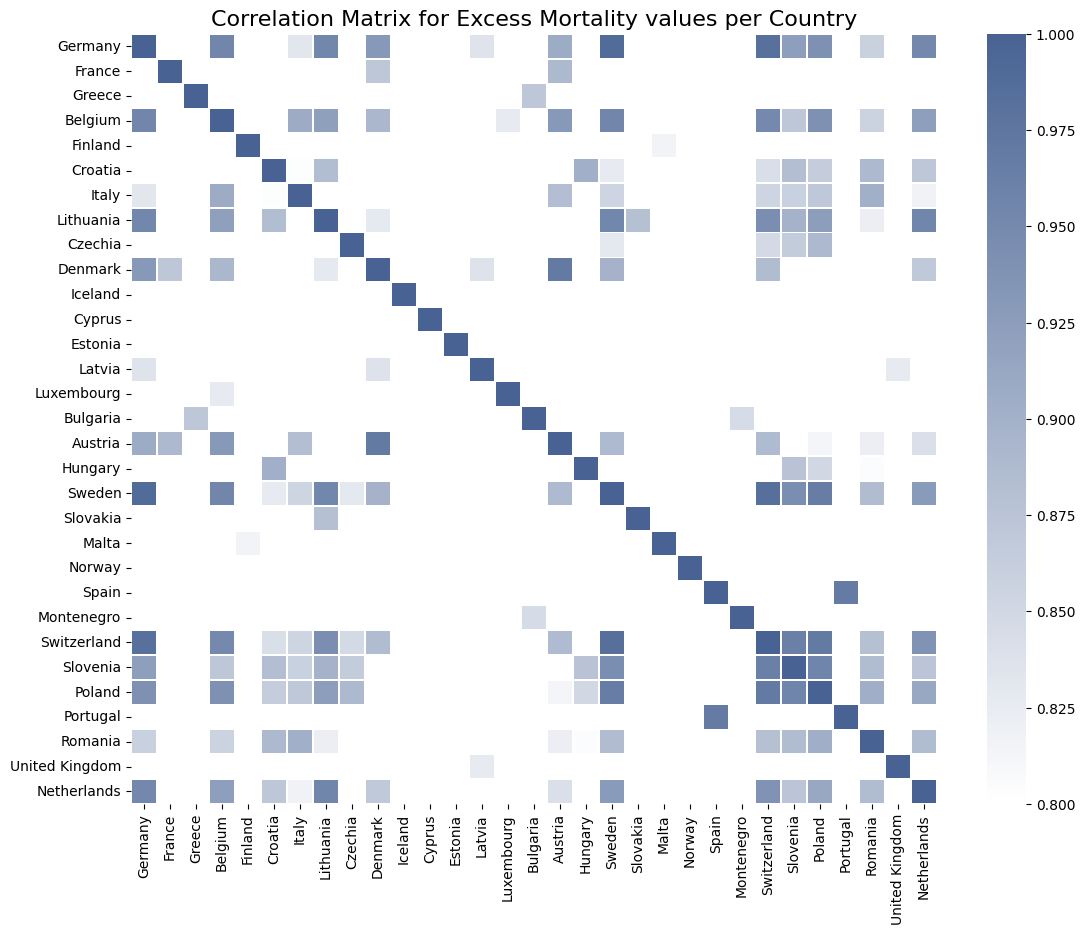

In [ ]:
fig, ax = plt.subplots(figsize=(13,10))

sns.heatmap(cor_np, linewidths=.5, ax=ax, vmin=0.8, vmax=1, cmap=mycmap,
            xticklabels=european_cts, yticklabels=european_cts)
ax.set_title('Correlation Matrix for Excess Mortality values per Country', fontsize=16)
plt.show()

In [ ]:
daily_means = {'AS': [], 'EU' : [], 'NAM' : [], 'SAM' : [], 'OC' : [], 'AF' : []}

print('Initializing the construction of heatmaps for every day.')

ct = 0
for this_day in dates_list:
    asia_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Asia').filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    europe_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Europe').filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    namerica_df = df.filter(F.col('date') == this_day).filter((F.col('continent') == 'North America')).filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    samerica_df = df.filter(F.col('date') == this_day).filter((F.col('continent') == 'South America')).filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    oceania_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Oceania').filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    africa_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Africa').filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])

    daily_means['AS'].append(asia_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['EU'].append(europe_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['NAM'].append(namerica_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['SAM'].append(samerica_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['OC'].append(oceania_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['AF'].append(africa_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])

    geo_as = pd.merge(left=geo_df, right=asia_df.toPandas(), how='inner', on='iso_code')
    geo_eu = pd.merge(left=geo_df, right=europe_df.toPandas(), how='inner', on='iso_code')
    geo_sam = pd.merge(left=geo_df, right=samerica_df.toPandas(), how='inner', on='iso_code')
    geo_nam = pd.merge(left=geo_df, right=namerica_df.toPandas(), how='inner', on='iso_code')
    geo_oc = pd.merge(left=geo_df, right=oceania_df.toPandas(), how='inner', on='iso_code')
    geo_af = pd.merge(left=geo_df, right=africa_df.toPandas(), how='inner', on='iso_code')

    fig, axes = plt.subplots(2,3, figsize=(18,14))

    col = 'reproduction_rate'
    cmap = mycmap

    vmin = min(geo_as[col].min(),geo_eu[col].min(),geo_sam[col].min(),geo_nam[col].min(),geo_oc[col].min(),geo_af[col].min())
    vmax = max(geo_as[col].max(),geo_eu[col].max(),geo_sam[col].max(),geo_nam[col].max(),geo_oc[col].max(),geo_af[col].max())
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

    for ax, data, cont, dims in zip(axes.flat,
                               [geo_eu, geo_nam, geo_af, geo_as, geo_sam, geo_oc],
                               ['Europe','North America','Africa','Asia','South America','Oceania'],
                               [[-13, 44, 33, 72],[-170, -50, 5, 85],[-20, 55, -38, 40],[25, 145, -10, 60],[-85, -32, -58, 15],[110,160,-45,0]]):
        title = f'{cont}'
        ax.axis('off')
        ax.axis(dims)
        data.plot(column=col, ax=ax, edgecolor='1.0', linewidth=1, norm=None, cmap=cmap)
        ax.set_title(title, fontdict={'fontsize': '18', 'fontweight': '3'})

    clb = fig.colorbar(sm, ax=axes.flat, location='bottom', fraction=0.056)
    clb.ax.set_title(f'COVID-19 Reproduction Rate as of {this_day}', fontsize=22)
    plt.savefig(f'cont_maps_{this_day}.png', bbox_inches='tight')
    plt.close(fig)
    ct += 1

print(f'Process complete. {ct} heatmap(s) were extracted, ready to be converted into a .gif file.')

Initializing the construction of heatmaps for every day.
Process complete. 59 heatmap(s) were extracted, ready to be converted into a .gif file.


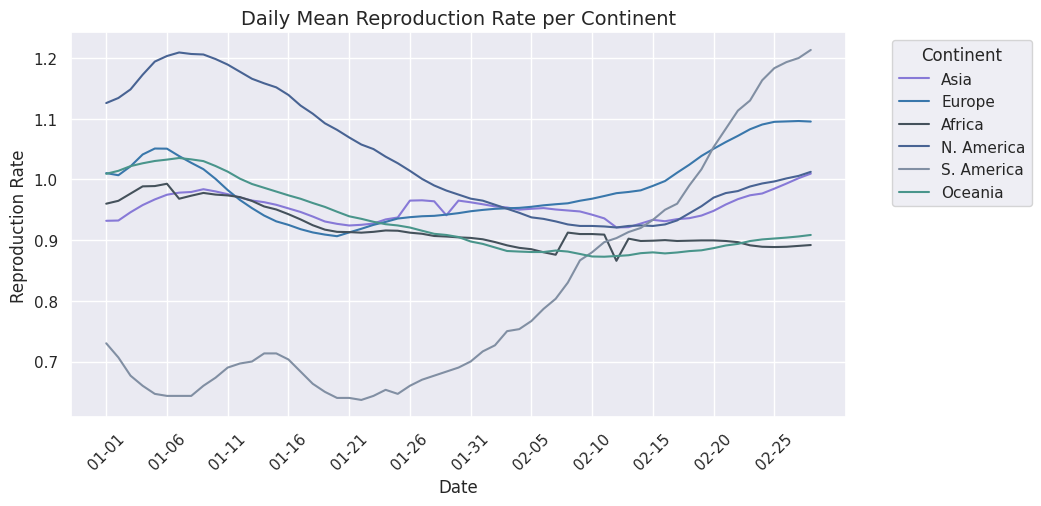

In [ ]:
sns.set(style = "darkgrid")

fig, ax = plt.subplots(1, 1, figsize=(10,5))

for key, col, lab in zip(daily_means,
                             [othercol1, othercol2, othercol3, mycol, mycomplcol, othercol4],
                             ['Asia', 'Europe', 'Africa', 'N. America', 'S. America', 'Oceania']): 
    ax.plot(alt_dts_list, daily_means[key], color=col, label = lab)
    
ax.set_xlabel("Date")
ax.set_ylabel("Reproduction Rate")
ax.set_title("Daily Mean Reproduction Rate per Continent", fontsize=14)
tick_marks = np.arange(len(alt_dts_list))
ax.set_xticks(tick_marks[::5])
ax.set_xticklabels(alt_dts_list[::5], rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title="Continent")
plt.show()

matplotlib.rc_file_defaults()

In [ ]:
countries_frame = df.select("location").distinct().collect()
exclusion_list = ['Europe', 'World', 'Asia', 'North America', 'South America', 'Africa', 'Oceania', 'Upper middle income']
countries_list = [str(countries_frame[x][0]) for x in range(len(countries_frame)) if str(countries_frame[x][0]) not in exclusion_list]

In [ ]:
country_dict = {}
for country in countries_list:
    filtered = df.filter(F.col('location') == country).filter(F.col('excess_mortality') != 0.0)
    if filtered.count() > 5:
        value = filtered.stat.corr("excess_mortality", "new_tests_smoothed")
    else:
        value = np.nan
    if not np.isnan(value):
        country_dict[country] = value

In [ ]:
country_dict = dict(sorted(country_dict.items(), reverse=True, key=lambda item: item[1]))
print("As far as the correlation between new tests and excess mortality is concerned:\n")
print("The ten countries with the highest correlation are:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, with correlation equal to {country_dict[ct]:.3f}.")
country_dict = dict(sorted(country_dict.items(), reverse=False, key=lambda item: item[1]))
print("\nThe ten countries with the lowest correlation are:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, with correlation equal to {country_dict[ct]:.3f}.")

As far as the correlation between new tests and excess mortality is concerned:

The ten countries with the highest correlation are:
Spain, with correlation equal to 0.976.
South Africa, with correlation equal to 0.968.
Peru, with correlation equal to 0.962.
Portugal, with correlation equal to 0.960.
Mexico, with correlation equal to 0.921.
Colombia, with correlation equal to 0.916.
United States, with correlation equal to 0.794.
Lithuania, with correlation equal to 0.762.
South Korea, with correlation equal to 0.723.
Ecuador, with correlation equal to 0.670.

The ten countries with the lowest correlation are:
Slovakia, with correlation equal to -0.883.
Denmark, with correlation equal to -0.828.
Romania, with correlation equal to -0.762.
New Zealand, with correlation equal to -0.729.
Switzerland, with correlation equal to -0.715.
Italy, with correlation equal to -0.698.
Sweden, with correlation equal to -0.643.
Luxembourg, with correlation equal to -0.543.
Guatemala, with correlation eq

In [ ]:
country_dict = {}
for country in countries_list:
    filtered = df.filter(F.col('location') == country).filter(F.col('excess_mortality') != 0.0)
    if filtered.count() > 5:
        value = filtered.stat.corr("excess_mortality", "total_vaccinations")
    else:
        value = np.nan
    if not np.isnan(value):
        country_dict[country] = value

In [ ]:
country_dict = dict(sorted(country_dict.items(), reverse=True, key=lambda item: item[1]))
print("As far as the correlation between excess mortality and the course of the vaccinations is concerned:\n")
print("The ten countries with the highest correlation are:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, with correlation equal to {country_dict[ct]:.3f}.")
country_dict = dict(sorted(country_dict.items(), reverse=False, key=lambda item: item[1]))
print("\nThe ten countries with the lowest correlation are:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, with correlation equal to {country_dict[ct]:.3f}.")

As far as the correlation between excess mortality and the course of the vaccinations is concerned:

The ten countries with the highest correlation are:
Croatia, with correlation equal to 0.937.
Cyprus, with correlation equal to 0.694.
Malta, with correlation equal to 0.667.
Peru, with correlation equal to 0.584.
Ecuador, with correlation equal to 0.410.
Chile, with correlation equal to 0.410.
Finland, with correlation equal to 0.380.
Greece, with correlation equal to 0.246.
Australia, with correlation equal to 0.215.
Bulgaria, with correlation equal to 0.206.

The ten countries with the lowest correlation are:
Germany, with correlation equal to -0.986.
United States, with correlation equal to -0.985.
Switzerland, with correlation equal to -0.955.
Denmark, with correlation equal to -0.952.
Sweden, with correlation equal to -0.945.
Belgium, with correlation equal to -0.925.
Lithuania, with correlation equal to -0.921.
Latvia, with correlation equal to -0.905.
Canada, with correlation eq

In [ ]:
this_day = dates_list[-1]
filtered_df = df.filter(F.col('date') == this_day)

mean_fem_smokers = filtered_df.filter(F.col('female_smokers') != 0.0).select(F.mean(F.col('female_smokers'))).collect()[0][0]
mean_male_smokers = filtered_df.filter(F.col('male_smokers') != 0.0).select(F.mean(F.col('male_smokers'))).collect()[0][0]
mean_diabetes = filtered_df.filter(F.col('diabetes_prevalence') != 0.0).select(F.mean(F.col('diabetes_prevalence'))).collect()[0][0]
mean_card = filtered_df.filter(F.col('cardiovasc_death_rate') != 0.0).select(F.mean(F.col('cardiovasc_death_rate'))).collect()[0][0]

print(f'Based on data up to {this_day}, the mean percentage of female smokers is {mean_fem_smokers:.2f}%, while the corresponding number for male smokers is {mean_male_smokers:.2f}%.')
print(f'In addition, the mean percentage of people suffering from diabetes (aged 20-79) is {mean_diabetes:.2f}%, while the mean number of deaths per 100.000 people due to cardiovascular conditions is {mean_card:.2f}.')

Based on data up to 2021-02-28, the mean percentage of female smokers is 10.40%, while the corresponding number for male smokers is 32.69%.
In addition, the mean percentage of people suffering from diabetes (aged 20-79) is 8.27%, while the mean number of deaths per 100.000 people due to cardiovascular conditions is 263.17.


In [ ]:
filtered_df = filtered_df.filter(F.col('diabetes_prevalence') != 0.0).filter(F.col('cardiovasc_death_rate') != 0.0).filter(F.col('female_smokers') != 0.0).filter(F.col('male_smokers') != 0.0)
filtered_df.orderBy("excess_mortality_cumulative_per_million", ascending=False).select(["location", "excess_mortality_cumulative_per_million", "female_smokers", "male_smokers", "diabetes_prevalence", "cardiovasc_death_rate"]).toPandas().head(5)

,location,excess_mortality_cumulative_per_million,female_smokers,male_smokers,diabetes_prevalence,cardiovasc_death_rate
0,Armenia,3613.725554,1.5,52.1,7.11,341.010
1,Mexico,3437.694368,6.9,21.4,13.06,152.783
2,Belarus,3287.984465,10.5,46.1,5.18,443.129
3,Russia,3151.540865,23.4,58.3,6.18,431.297
4,Albania,2854.503445,7.1,51.2,10.08,304.195


In [ ]:
filtered_df.orderBy("excess_mortality_cumulative_per_million", ascending=True).select(["location", "excess_mortality_cumulative_per_million", "female_smokers", "male_smokers", "diabetes_prevalence", "cardiovasc_death_rate"]).toPandas().head(5)

,location,excess_mortality_cumulative_per_million,female_smokers,male_smokers,diabetes_prevalence,cardiovasc_death_rate
0,Seychelles,-1678.293398,7.1,35.7,10.55,242.648
1,Barbados,-832.093651,1.9,14.5,13.57,170.050
2,Uruguay,-682.380568,14.0,19.9,6.93,160.708
3,Mongolia,-605.836333,5.5,46.5,4.82,460.043
4,Malaysia,-465.227889,1.0,42.4,16.74,260.942


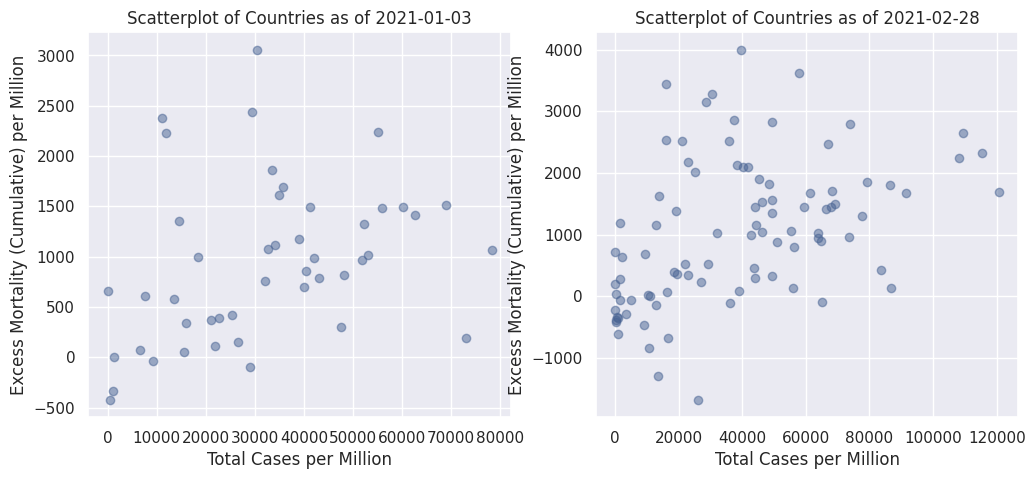

In [ ]:
sns.set(style = "darkgrid")
    
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(12,5))

for idx, (ax,this_day) in enumerate(zip([ax1,ax2],[exc_dates_list[0],exc_dates_list[-1]])):
    
    eff_df = df.filter(F.col('excess_mortality_cumulative_per_million') != 0.0).filter(F.col('date') == this_day).select(['total_cases_per_million','excess_mortality_cumulative_per_million','location'])

    pdf = eff_df.select(['total_cases_per_million','excess_mortality_cumulative_per_million']).toPandas()

    points = ax.scatter(pdf.total_cases_per_million, pdf.excess_mortality_cumulative_per_million,
                                  color=mycol, alpha=0.5)

    ax.set_title(f'Scatterplot of Countries as of {this_day}')
    ax.set_xlabel('Total Cases per Million')
    ax.set_ylabel('Excess Mortality (Cumulative) per Million')

plt.show()

matplotlib.rc_file_defaults()

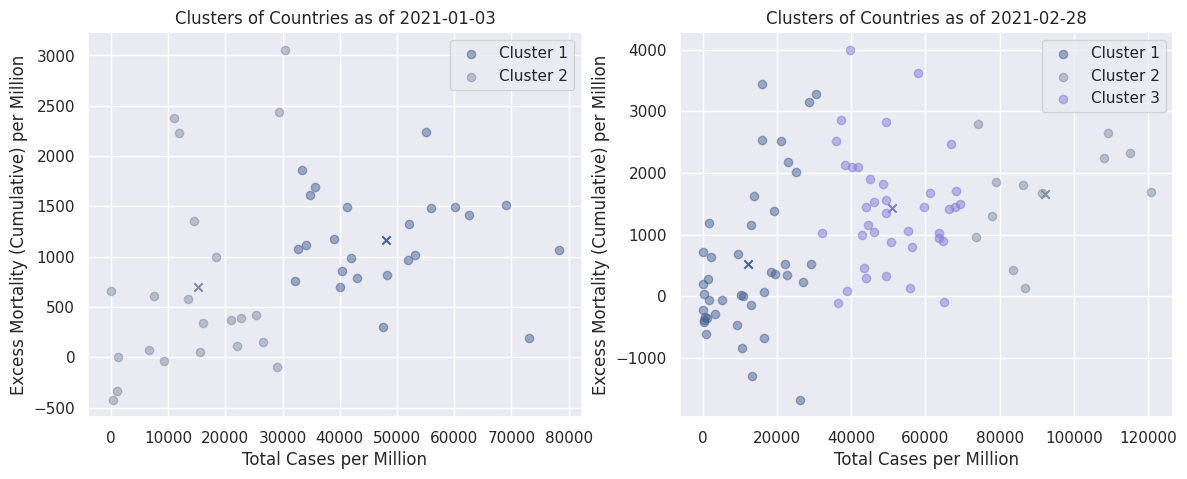

In [ ]:
from pyspark.ml.clustering import KMeans

sns.set(style = "darkgrid")

numclusters = [2,3]
colors = [mycol, mycomplcol, othercol1, othercol2, othercol3, othercol4]
    
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for idx, (ax,this_day) in enumerate(zip([ax1,ax2],[exc_dates_list[0],exc_dates_list[-1]])):
    
    eff_df = df.filter(F.col('excess_mortality_cumulative_per_million') != 0.0).filter(F.col('date') == this_day).filter(F.col('date') == this_day).select(['total_cases_per_million','excess_mortality_cumulative_per_million','location'])

    vectorAssembler = VectorAssembler(inputCols = ['total_cases_per_million','excess_mortality_cumulative_per_million'], outputCol = "features")
    feat_df = vectorAssembler.transform(eff_df)
    feat_df = feat_df.select(['features','location'])

    kmeans = KMeans().setK(numclusters[idx]).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
    model = kmeans.fit(feat_df)
    transformed = model.transform(feat_df)
    centroids = model.clusterCenters()

    transformed = transformed.join(eff_df, 'location')
    
    clusters, centers, images = {}, {}, {}

    for i in range(numclusters[idx]):

        clusters[i] = transformed.filter(F.col('cluster')==i).select(['location','cluster','total_cases_per_million',
                                                              'excess_mortality_cumulative_per_million']).toPandas().set_index('location')

        images[i] = ax.scatter(clusters[i].total_cases_per_million, clusters[i].excess_mortality_cumulative_per_million,
                                  color=colors[i], alpha=0.5)
        centers[i] = ax.scatter(centroids[i][0], centroids[i][1], color=colors[i], marker='x')

    clusttuple = (images[i] for i in range(numclusters[idx]))
    clustnames = ('Cluster '+str(i+1) for i in range(numclusters[idx]))

    ax.legend(clusttuple, clustnames, loc='best')

    ax.set_title(f'Clusters of Countries as of {this_day}')
    ax.set_xlabel('Total Cases per Million')
    ax.set_ylabel('Excess Mortality (Cumulative) per Million')

plt.show()

matplotlib.rc_file_defaults()

In [ ]:
print(*clusters[2].index, sep=', ')

Albania, Armenia, Austria, Belgium, Bosnia and Herzegovina, Brazil, Bulgaria, Chile, Colombia, Croatia, Cyprus, Denmark, Estonia, France, French Polynesia, Georgia, Hungary, Ireland, Italy, Kosovo, Latvia, Lebanon, Liechtenstein, Malta, Moldova, Monaco, Netherlands, North Macedonia, Peru, Poland, Qatar, Romania, Serbia, Spain, Sweden, Switzerland, Ukraine, United Kingdom


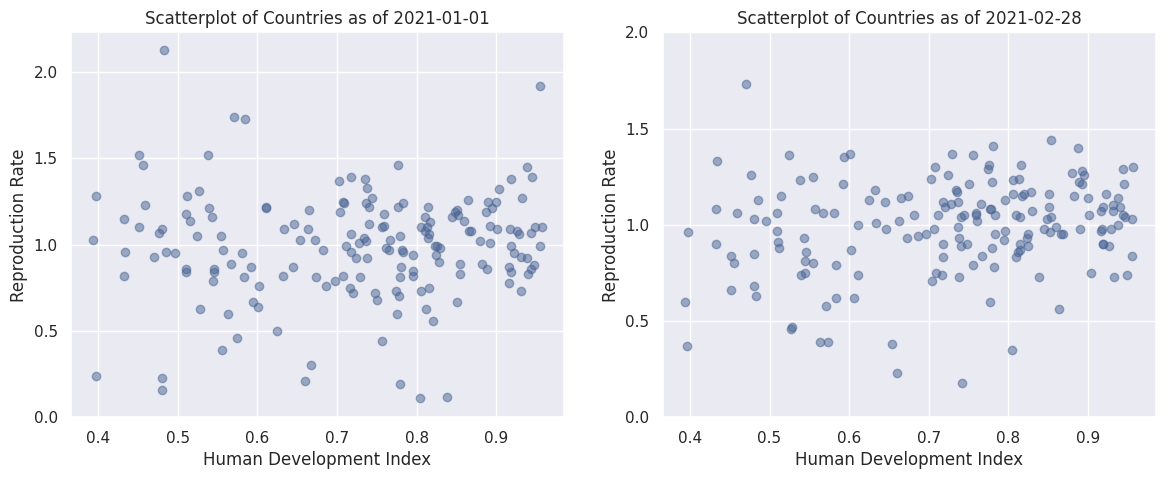

In [ ]:
sns.set(style = "darkgrid")
    
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for idx, (ax,this_day) in enumerate(zip([ax1,ax2],[dates_list[0],dates_list[-1]])):
    
    eff_df = df.filter(F.col('human_development_index') != 0.0).filter(F.col('reproduction_rate') != 0.0).filter(F.col('date') == this_day).select(['human_development_index','reproduction_rate','location'])

    pdf = eff_df.select(['human_development_index','reproduction_rate']).toPandas()

    points = ax.scatter(pdf.human_development_index, pdf.reproduction_rate, color=mycol, alpha=0.5)

    ax.set_title(f'Scatterplot of Countries as of {this_day}')
    ax.set_yticks([0.0,0.5,1.0,1.5,2.0])
    ax.set_xlabel('Human Development Index')
    ax.set_ylabel('Reproduction Rate')

plt.show()

matplotlib.rc_file_defaults()

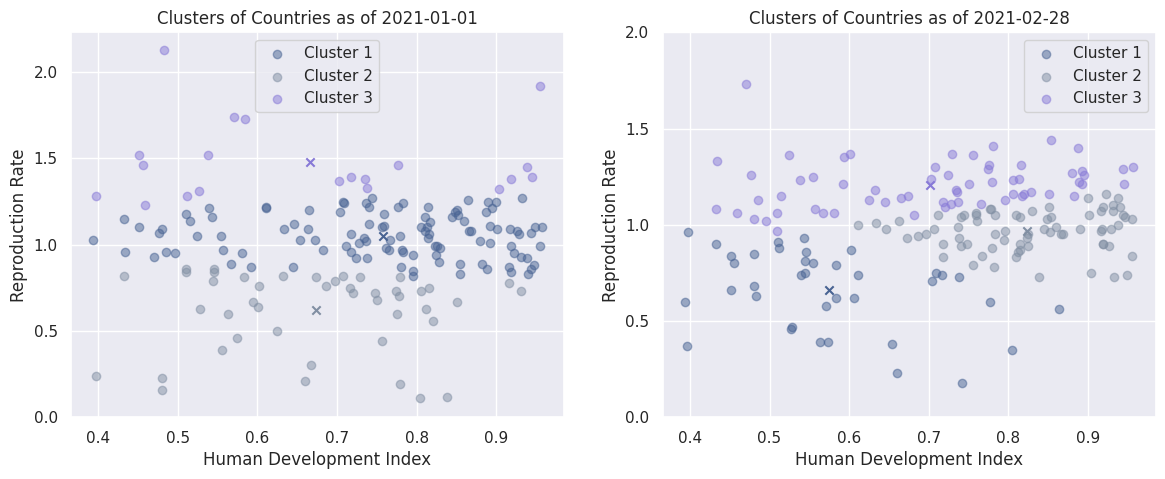

In [ ]:
sns.set(style = "darkgrid")

numclusters = [3,3]
colors = [mycol, mycomplcol, othercol1, othercol2, othercol3, othercol4]
    
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for idx, (ax,this_day) in enumerate(zip([ax1,ax2],[dates_list[0],dates_list[-1]])):
    
    eff_df = df.filter(F.col('human_development_index') != 0.0).filter(F.col('reproduction_rate') != 0.0).filter(F.col('date') == this_day).select(['human_development_index','reproduction_rate','location'])

    vectorAssembler = VectorAssembler(inputCols = ['human_development_index','reproduction_rate'], outputCol = "features")
    feat_df = vectorAssembler.transform(eff_df)
    feat_df = feat_df.select(['features','location'])

    kmeans = KMeans().setK(numclusters[idx]).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
    model = kmeans.fit(feat_df)
    transformed = model.transform(feat_df)
    centroids = model.clusterCenters()

    transformed = transformed.join(eff_df, 'location')
    
    clusters, centers, images = {}, {}, {}

    for i in range(numclusters[idx]):

        clusters[i] = transformed.filter(F.col('cluster')==i).select(['location','cluster','reproduction_rate',
                                                              'human_development_index']).toPandas().set_index('location')

        images[i] = ax.scatter(clusters[i].human_development_index, clusters[i].reproduction_rate, color=colors[i], alpha=0.5)
        centers[i] = ax.scatter(centroids[i][0], centroids[i][1], color=colors[i], marker='x')

    clusttuple = (images[i] for i in range(numclusters[idx]))
    clustnames = ('Cluster '+str(i+1) for i in range(numclusters[idx]))

    ax.legend(clusttuple, clustnames, loc='best')

    ax.set_title(f'Clusters of Countries as of {this_day}')
    ax.set_yticks([0.0,0.5,1.0,1.5,2.0])
    ax.set_xlabel('Human Development Index')
    ax.set_ylabel('Reproduction Rate')

plt.show()

matplotlib.rc_file_defaults()